In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

from sod_model import set_sod_model, optimizer


In [12]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_trained_model():
    model = set_sod_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    opt = optimizer()

    base = os.getcwd()
    ckpt_dir = os.path.join(base, "checkpoints")

    ckpt = tf.train.Checkpoint(model=model, optimizer=opt, step=tf.Variable(0))
    manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=3)

    if manager.latest_checkpoint:
        print(f"Restoring from {manager.latest_checkpoint}")
        ckpt.restore(manager.latest_checkpoint).expect_partial()
    else:
        print("No checkpoint found. Train the model first.")

    return model


In [13]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at path: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
    image = image.astype(np.float32) / 255.0
    return image


In [14]:
def predict(model, image):
    input_tensor = tf.expand_dims(image, axis=0)

    start = time.time()
    pred = model(input_tensor, training=False)
    end = time.time()

    infer_time = end - start
    pred_mask = tf.cast(pred[0] > 0.5, tf.float32).numpy().squeeze()

    return pred_mask, infer_time


In [15]:
def show_results(image, mask, infer_time=None):
    img = image.copy()
    m = mask.astype(np.float32)

    overlay = img.copy()
    overlay[..., 0] = np.maximum(overlay[..., 0], m)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted mask")
    plt.imshow(m, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    if infer_time is not None:
        plt.title(f"Overlay\n(inference: {infer_time:.4f}s)")
    else:
        plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [16]:
model = load_trained_model()


Restoring from c:\Users\mil\Desktop\CNN Project\CNN Project\checkpoints\ckpt-13


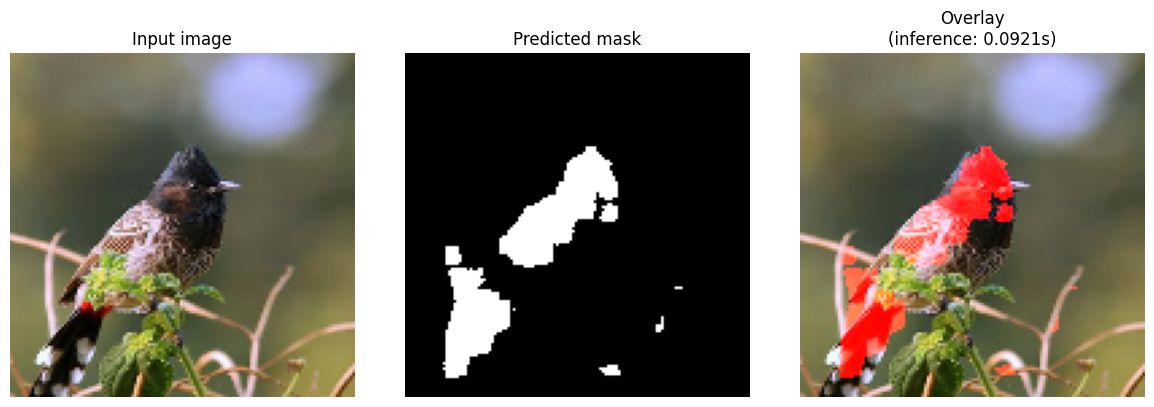

Inference time: 0.0921 seconds


In [19]:
image_path = "Dataset/Image/ILSVRC2012_test_00000105.jpg"  # change this

image = preprocess_image(image_path)
mask, infer_time = predict(model, image)
show_results(image, mask, infer_time)
print(f"Inference time: {infer_time:.4f} seconds")
